In [130]:
import math
import random

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import kornia as K
from scipy import ndimage
import numpy as np

In [131]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Image Size: torch.Size([28, 28])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 100, 237,
         121,   0,   0,   0,   0,   0,   0,  13,  48,  18,   0,   0,   0,   0],
        [  0,

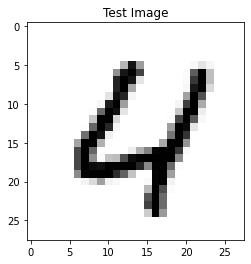

In [132]:
DATASET_PATH = "./data"

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                AddGaussianNoise(0., .75)])

train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

TEST_IMG_INDEX = 64

img = train_set.data[TEST_IMG_INDEX]
print(f"Image Size: {img.size()}")
print(img)
plt.title("Test Image")
plt.imshow(img, cmap="Greys")

train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

In [133]:
input_imgs = torch.clone(train_set.data)
input_imgs.data.to(torch.float)
print(input_imgs.data.size())
noise = torch.rand(input_imgs.data.size(), device=train_set.data.device) * 255 - 255

noisy_imgs = input_imgs.data.add(noise.data.int())
noisy_imgs.data.clamp_(min=-255, max=255)

clean_img = input_imgs.data[TEST_IMG_INDEX]
noisy_img = noisy_imgs.data[TEST_IMG_INDEX]

noisy_img_removed = torch.clone(noisy_img)

rand_chance = np.random.randint(0, 28, size=28)
rand_lines = np.random.randint(0, 28, size=28)

for i in rand_lines:
    if rand_chance[i] < 9:
        for j in range(noisy_img_removed.size()[0]):
            noisy_img_removed[j][rand_lines[i]] = 0

noisy_img_old = noisy_img
noisy_img = noisy_img_removed

torch.Size([60000, 28, 28])


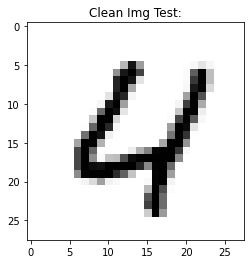

In [134]:
plt.title("Clean Img Test:")
plt.imshow(clean_img, cmap="Greys")

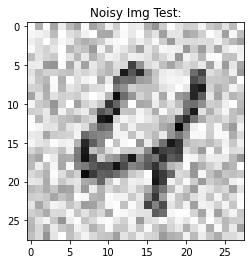

In [135]:
plt.title("Noisy Img Test:")
plt.imshow(noisy_img_old, cmap="Greys")

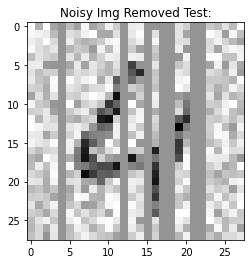

In [136]:
plt.title("Noisy Img Removed Test:")
plt.imshow(noisy_img_removed, cmap="Greys")

In [137]:
ALPHA = 0.01
BETA = 0.01

Gradient Calculation Test:


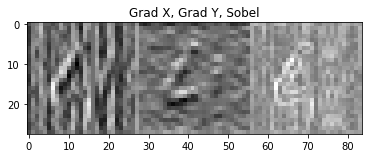

In [138]:
print("Gradient Calculation Test:")

sy = ndimage.sobel(noisy_img,axis=0,mode='constant')
sx = ndimage.sobel(noisy_img,axis=1,mode='constant')

sobel=np.hypot(sx,sy)
plots = np.concatenate((sx, sy, sobel), axis = 1)
plt.title("Grad X, Grad Y, Sobel")
plt.imshow(plots,cmap=plt.cm.gray)
plt.show()

In [139]:
def grads(img):
    sy = ndimage.sobel(img,axis=0,mode='nearest')
    sx = ndimage.sobel(img,axis=1,mode='nearest')

    #sobel=np.hypot(sx,sy)

    return sx, sy

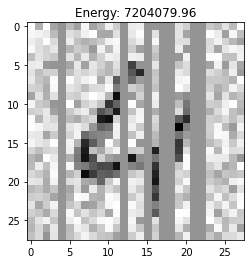

In [140]:
e1 = ALPHA * sx + BETA * sy
e2 = torch.subtract(clean_img, noisy_img)
e2 = e2.numpy()
e2 = np.square(e2)
e2 = np.multiply(e2, 0.5)
energy = np.add(e1, e2)
plt.title(f"Energy: {np.sum(energy)}")
plt.imshow(noisy_img, cmap="Greys")

In [141]:
def energy(clean_img, noisy_img):
    e1 = ALPHA * sx + BETA * sy
    e2 = torch.subtract(clean_img, noisy_img)
    e2 = e2.numpy()
    e2 = np.square(e2)
    e2 = np.multiply(e2, 0.5)
    energy = np.add(e1, e2)
    return np.sum(energy)


In [142]:
learning_rate = 1e-3
iterations = []
for i in range(0, 2048):
    dx, dy = grads(noisy_img)
    dxx, dyx = grads(dx/np.sqrt(np.square(dx + 0.0001)))
    dxy, dyy = grads(dy/np.sqrt(np.square(dy + 0.0001)))

    du = np.add((ALPHA * dxx + BETA * dyy), np.subtract(clean_img, noisy_img))
    noisy_img = noisy_img + learning_rate * du

    if (i % 64 == 0):
        iterations.append(noisy_img)


In [143]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

8.0
Iteration 0 Energy: 7189676.446277907
Iteration 3 Energy: 4899673.277672561
Iteration 7 Energy: 2935274.759041923
Iteration 11 Energy: 1758411.945360022
Iteration 15 Energy: 1053368.0472895144


<Figure size 432x288 with 0 Axes>

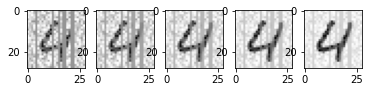

In [144]:
plt.figure()

f, axarr = plt.subplots(1, 5)
plt.set_cmap("Greys")

print(iterations.__len__() / 4)

for i in range(0, 5):
    print(f"Iteration {(i * 4 - 1, 0)[i ==0]} Energy: {energy(clean_img, iterations[(i * 4 - 1, 0)[i ==0]])}")
    axarr[i].imshow(iterations[(i * 4 - 1, 0)[i ==0]])